# In this model i train a simple classifier
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://www.kaggle.com/gti-upm/leapgestrecog/version/1

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache
os.chdir('/Users/joeholt/Documents/College Local/Current/CS 639/proj') 
%matplotlib inline

In [6]:
imshow = lambda im: plt.imshow(im, cmap='gray')
def imshow_group(imgs):
    f, axarr = plt.subplots(1,len(imgs), figsize=(20, 6))
    for idx, img in enumerate(imgs):
        axarr[idx].imshow(img, cmap='gray')

In [8]:
path_plus = os.path.join(os.getcwd(), 'data', 'leapGestRecog', '00', '01_palm', 'frame_00_01_0001.png')

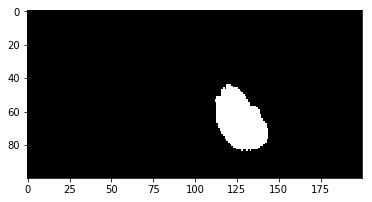

In [10]:
def process_img(path, new_size, threshold=0.4):
    img = img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (new_size[0],  new_size[1]))
    img = cv2.threshold(img, 255*threshold, 255, cv2.THRESH_BINARY)[1]
    return img
    
img = process_img(path_plus, (200, 100))
imshow(img)

In [11]:
class_labels = {
    'palm': 0,
    'l': 1,
    'fist': 2,
    'fist_moved': 3,
    'thumb': 4,
    'index': 5,
    'ok': 6,
    'palm_moved': 7,
    'c': 8,
    'down': 9
}

In [13]:
def load_dataset(transformed_size=(100, 200)):
    """
    Loads dataset and returns X, y. Loads dataset from leapGestRecog
    data store in this project
    
    Returns:
    X representing processed dataset images in arrays
    y representing classes as strings for those items
    """
    os.chdir('/Users/joeholt/Documents/College Local/Current/CS 639/proj')
    root_data_dir = os.path.join(os.getcwd(), 'data', 'leapGestRecog')
    
    y = []
    X = []
    
    # get data
    for subject_dir in os.listdir(root_data_dir):
        if subject_dir == '.ipynb_checkpoints':
            continue
        
        subject_path = os.path.join(root_data_dir, subject_dir)
        
        for class_dir in os.listdir(subject_path):
            
            class_path = os.path.join(subject_path, class_dir)
            class_name = class_dir.split('_')[1]
            
            for filename in os.listdir(class_path):
                
                if filename.split('.')[1] != 'png':
                    continue
                
                full_path = os.path.join(class_path, filename)
                img = process_img(full_path, transformed_size[::-1])
                
                X.append(img)
                y.append(class_name)
    
    # convert to numpy
    X = np.array(X, dtype="uint8")
    X = X.reshape(len(X), transformed_size[0], transformed_size[1], 1)
    y = [class_labels[itm] for itm in y]
    y = np.array(y)
    
    return X, y

In [14]:
# get dataset
transformed_img_size = (100, 200)
X, y = load_dataset(transformed_img_size)

In [15]:
assert(len(y) == len(X))

In [16]:
X.shape

(20000, 100, 200, 1)

In [17]:
y

array([4, 4, 4, ..., 2, 2, 2])

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [147]:
in_size = (100, 200)

In [192]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 in channel, 6 new feature detectors, 5 kernel size, 1 stride (meaning output channels are same size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16544, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        #print('in:', x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print('pool1:', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('pool2:', x.shape)
        x = x.view(-1, 16 * 22 * 47)
        #print('x view:', x.shape)
        x = F.relu(self.fc1(x))
        #print('x fc1:', x.shape)
        x = F.relu(self.fc2(x))
        #print('x fc2:', x.shape)
        x = self.fc3(x)
        #print('x fin:', x)
        return x


net = Net()

In [193]:
# loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [195]:
# train
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    batch_size = 50
    for idx in range(0, len(X) - batch_size, batch_size):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.FloatTensor(X[idx: idx + batch_size]).permute(0, 3, 1, 2)
        #print(inputs.shape)
        labels = torch.LongTensor(y[idx: idx + batch_size])
        #print(labels.shape)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(len(outputs))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if idx % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,  2001] loss: 0.045
[1,  4001] loss: 0.045
[1,  6001] loss: 0.045
[1,  8001] loss: 0.044
[1, 10001] loss: 0.045
[1, 12001] loss: 0.042
[1, 14001] loss: 0.043
[1, 16001] loss: 0.044
[1, 18001] loss: 0.041
[2,     1] loss: 0.001
[2,  2001] loss: 0.043
[2,  4001] loss: 0.035
[2,  6001] loss: 0.042
[2,  8001] loss: 0.035
[2, 10001] loss: 0.042
[2, 12001] loss: 0.034
[2, 14001] loss: 0.040
[2, 16001] loss: 0.037
[2, 18001] loss: 0.025
Finished Training


In [ ]:
class_labels = {
    'palm': 0,
    'l': 1,
    'fist': 2,
    'fist_moved': 3,
    'thumb': 4,
    'index': 5,
    'ok': 6,
    'palm_moved': 7,
    'c': 8,
    'down': 9
}

In [258]:
# see how it worked
classes = list(class_labels.keys())
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
    
    batch_size = 50
    for idx in range(0, len(X) - batch_size, batch_size):
        # get data
        inputs = torch.FloatTensor(X[idx: idx + batch_size]).permute(0, 3, 1, 2)
        labels = torch.LongTensor(y[idx: idx + batch_size])
        # run through model
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        # predict
        for idx in range(outputs.shape[0]):
            label = predicted[idx]
            actual = labels[idx]
            if actual == label:
                class_correct[label] += 1
            class_total[label] += 1

In [261]:
class_total

[3345.0, 202.0, 9508.0, 0.0, 517.0, 271.0, 1449.0, 0.0, 1838.0, 2820.0]

In [361]:
print("Accuracy by class:")
for idx, c in enumerate(classes):
    if class_total[idx] != 0:
        print("\t{:<12s}   acc = {:04f}".format(c, class_correct[idx]/class_total[idx]))
    else:
        print("\t{:<12s}   acc = {:04f}".format(c, 0.0))

Accuracy by class:
	palm           acc = 0.457100
	l              acc = 0.896040
	fist           acc = 0.350126
	fist_moved     acc = 0.000000
	thumb          acc = 0.829787
	index          acc = 0.118081
	ok             acc = 0.628019
	palm_moved     acc = 0.000000
	c              acc = 0.459195
	down           acc = 0.471277


In [290]:
def predict(img):
    in_to_model = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)
    out = net(in_to_model)
    _, predicted = torch.max(out, 1)
    return labels[predicted]
predict(X[0])

'ok'

down predicted to be down


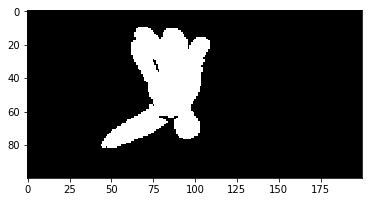

In [343]:
idx = 15000
test = torch.FloatTensor(X[idx]).squeeze()
imshow(test)
print("{} predicted to be {}".format(labels[y[idx]], predict(test.unsqueeze(2))))